In [12]:
import yfinance as yf
import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

print("🚀 Starting Prophet Model...")
print("="*70)

emiten = 'BUMI'

🚀 Starting Prophet Model...


### LANGKAH 1: Download Data & Rekayasa Fitur

In [13]:
print("\n📥 Downloading stock data...")
data_raw = yf.download(emiten + '.JK', period="5y",interval="1d", progress=False)
data = data_raw.copy()

if isinstance(data.columns, pd.MultiIndex):
    data.columns = [col[0] for col in data.columns]

print("✅ Data downloaded successfully")
print(f"   Shape: {data.shape}")


📥 Downloading stock data...
✅ Data downloaded successfully
   Shape: (1208, 5)


In [14]:
# Tambahkan Fitur Teknikal
print("\n🔧 Creating technical indicators...")
data['Prev Close'] = data['Close'].shift(1)
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()

# RSI
delta = data['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
gain_avg = gain.rolling(window=14).mean()
loss_avg = loss.rolling(window=14).mean()
rs = gain_avg / (loss_avg + 1e-8)
data['RSI'] = 100 - (100 / (1 + rs))

# MACD
data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA12'] - data['EMA26']
data['Signal Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Bollinger Bands
data['BB_Upper'] = data['Close'].rolling(window=20).mean() + 2*data['Close'].rolling(window=20).std()
data['BB_Lower'] = data['Close'].rolling(window=20).mean() - 2*data['Close'].rolling(window=20).std()

# ATR
high_low = data['High'] - data['Low']
high_close = abs(data['High'] - data['Close'].shift(1))
low_close = abs(data['Low'] - data['Close'].shift(1))
true_range = pd.concat([high_low, high_close, low_close], axis=1)
data['ATR'] = true_range.max(axis=1).rolling(window=14).mean()

# Stochastic
data['Stochastic_K'] = 100 * (data['Close'] - data['Low'].rolling(window=14).min()) / \
                       (data['High'].rolling(window=14).max() - data['Low'].rolling(window=14).min())
data['Stochastic_D'] = data['Stochastic_K'].rolling(window=3).mean()

# CCI
data['CCI'] = (data['Close'] - data['Close'].rolling(window=20).mean()) / \
              (0.015 * data['Close'].rolling(window=20).std())

# OBV
data['OBV'] = np.where(data['Close'] > data['Close'].shift(1), data['Volume'],
                       np.where(data['Close'] < data['Close'].shift(1), -data['Volume'], 0))
data['OBV'] = data['OBV'].cumsum()

# Lag features
for i in range(1, 6):
    data[f'Lag{i}'] = data['Close'].shift(i)

data = data.dropna()
data = data.reset_index()

print(f"✅ Technical indicators created")
print(f"   Final shape: {data.shape}")


🔧 Creating technical indicators...
✅ Technical indicators created
   Final shape: (1159, 26)


### LANGKAH 2: Persiapan Data untuk Prophet

In [15]:
print("\n📊 Preparing data for Prophet...")
df_prophet = data.rename(columns={'Date': 'ds', 'Close': 'y'})

regressors = [
    'Prev Close', 'MA20', 'MA50', 'MACD', 'Signal Line',
    'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'RSI',
    'BB_Upper', 'BB_Lower', 'ATR', 'Stochastic_K', 'Stochastic_D', 'CCI', 'OBV', 'Volume'
]

# Split data
train_size = int(len(df_prophet) * 0.8)
train_df = df_prophet[:train_size]
test_df = df_prophet[train_size:]

print(f"✅ Data split completed")
print(f"   Training samples: {len(train_df)}")
print(f"   Testing samples: {len(test_df)}")
print(f"   Number of features: {len(regressors)}")


📊 Preparing data for Prophet...
✅ Data split completed
   Training samples: 927
   Testing samples: 232
   Number of features: 19


In [16]:
print("\n⚖️  Normalizing technical features...")

# Kita gunakan .copy() agar tidak muncul SettingWithCopyWarning
train_df = df_prophet[:train_size].copy()
test_df = df_prophet[train_size:].copy()

scaler = MinMaxScaler()

# Hanya normalisasi kolom FITUR (regressors), JANGAN normalisasi 'y' (Target)
# Fit pada training, transform pada training & testing
train_df[regressors] = scaler.fit_transform(train_df[regressors])
test_df[regressors] = scaler.transform(test_df[regressors])

print("✅ Features scaled to 0-1 range")


⚖️  Normalizing technical features...
✅ Features scaled to 0-1 range


### LANGKAH 3: Membuat & Melatih Model Prophet

In [17]:
print("\n🤖 Training Prophet model...")
model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    n_changepoints=25
)

for regressor in regressors:
    model_prophet.add_regressor(regressor, prior_scale=10.0)

model_prophet.fit(train_df)
print("✅ Prophet model trained successfully")


🤖 Training Prophet model...


20:57:12 - cmdstanpy - INFO - Chain [1] start processing
20:57:12 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet model trained successfully


### LANGKAH 4: Membuat Prediksi

In [18]:
print("\n🔮 Making predictions...")

# Prediksi Prophet pada data test
future = test_df.drop(columns='y')
forecast = model_prophet.predict(future)
prophet_pred_test = forecast['yhat'].values

y_test = test_df['y'].values

print(f"✅ Predictions completed")
print(f"   Test predictions: {len(prophet_pred_test)}")


🔮 Making predictions...
✅ Predictions completed
   Test predictions: 232


### LANGKAH 5: Evaluasi Model

In [19]:
print("\n📈 Evaluating model performance...")

# Metrik Prophet
mae_prophet = mean_absolute_error(y_test, prophet_pred_test)
rmse_prophet = np.sqrt(mean_squared_error(y_test, prophet_pred_test))
r2_prophet = r2_score(y_test, prophet_pred_test)
mape_prophet = np.mean(np.abs((y_test - prophet_pred_test) / y_test)) * 100

# --- PERHITUNGAN DA SESUAI RUMUS ---
# T adalah jumlah total interval perubahan (n-1)
T = len(y_test) - 1

# 1. Hitung perubahan arah aktual dan prediksi
actual_diff = np.diff(y_test)
prophet_diff = np.diff(prophet_pred_test)

# 2. Definisikan ai (Indikator: 1 jika arah sama, 0 jika berbeda)
ai_prophet = (np.sign(actual_diff) == np.sign(prophet_diff)).astype(int)

# 3. Hitung DA = (1/T) * Sum(ai) * 100%
da_prophet = (1/T) * np.sum(ai_prophet) * 100

print("\n" + "="*70)
print("📊 PROPHET MODEL - EVALUATION METRICS")
print("="*70)
print(f"\n   RMSE  : {rmse_prophet:.4f}")
print(f"   MAE   : {mae_prophet:.4f}")
print(f"   R²    : {r2_prophet:.4f}")
print(f"   MAPE  : {mape_prophet:.2f}%")
print(f"   DA    : {da_prophet:.2f}%")
print("="*70)


📈 Evaluating model performance...

📊 PROPHET MODEL - EVALUATION METRICS

   RMSE  : 2.5853
   MAE   : 1.7987
   R²    : 0.9986
   MAPE  : 1.24%
   DA    : 85.71%


### LANGKAH 6: Visualisasi


📊 Creating visualizations...
✅ Visualization saved as 'prophet_results.png'


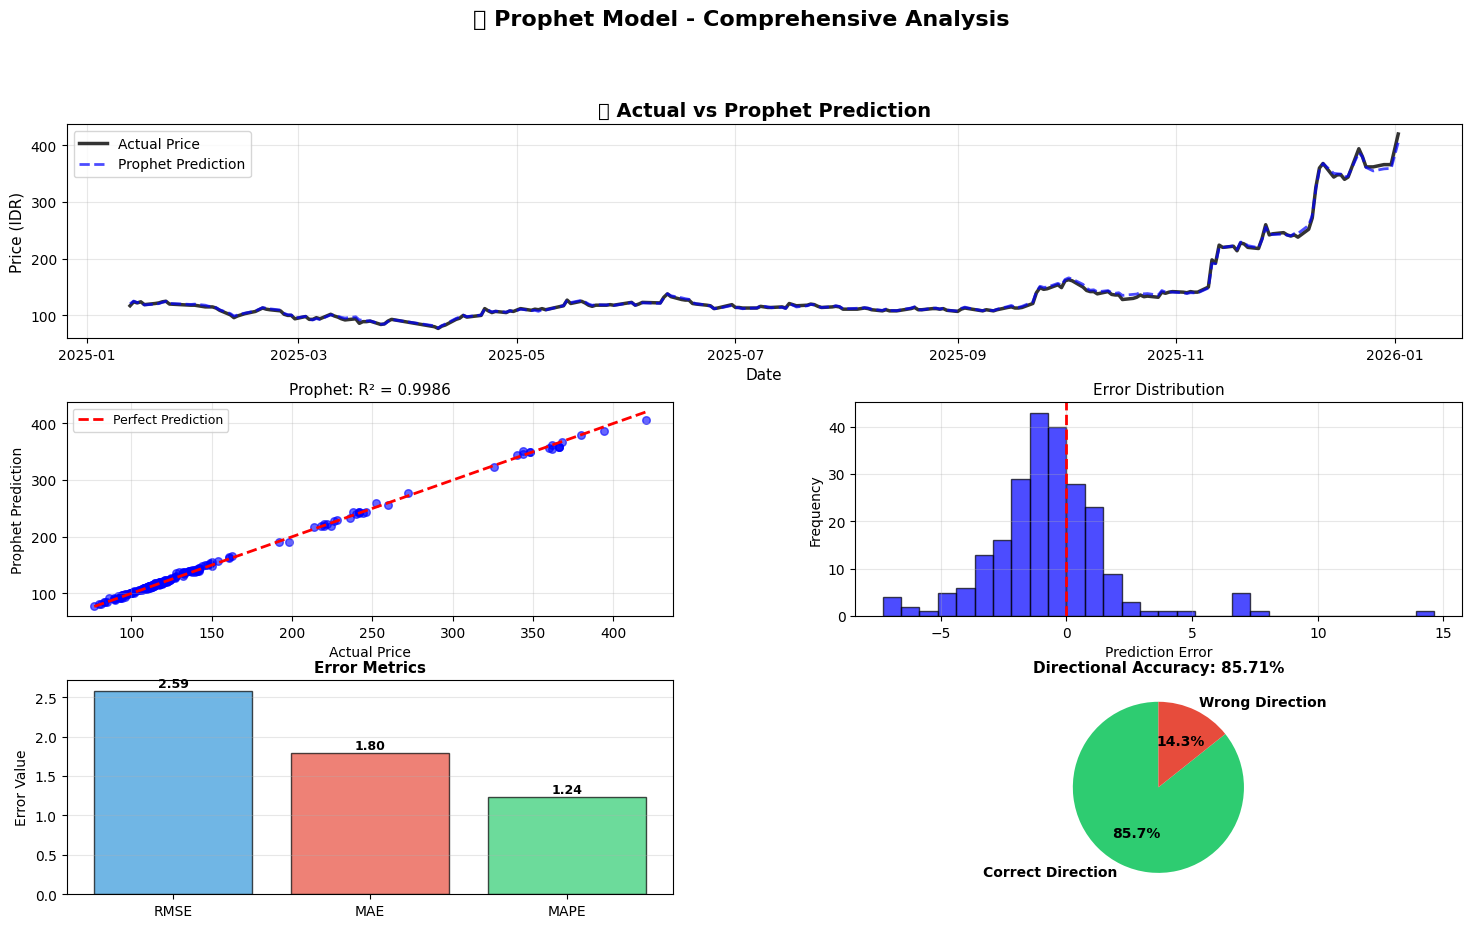

In [20]:
print("\n📊 Creating visualizations...")

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Time Series
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(test_df['ds'], y_test, label='Actual Price', color='black', linewidth=2.5, alpha=0.8)
ax1.plot(test_df['ds'], prophet_pred_test, label='Prophet Prediction', color='blue',
         linestyle='--', linewidth=2, alpha=0.7)
ax1.set_title('📈 Actual vs Prophet Prediction', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Price (IDR)', fontsize=11)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Scatter Plot
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(y_test, prophet_pred_test, alpha=0.6, color='blue', s=30)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Price', fontsize=10)
ax2.set_ylabel('Prophet Prediction', fontsize=10)
ax2.set_title(f'Prophet: R² = {r2_prophet:.4f}', fontsize=11)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Residuals
ax3 = fig.add_subplot(gs[1, 1])
prophet_residuals = y_test - prophet_pred_test
ax3.hist(prophet_residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Prediction Error', fontsize=10)
ax3.set_ylabel('Frequency', fontsize=10)
ax3.set_title('Error Distribution', fontsize=11)
ax3.grid(True, alpha=0.3)

# Plot 4: Metrics Bar Chart
ax4 = fig.add_subplot(gs[2, 0])
metrics = ['RMSE', 'MAE', 'MAPE']
metric_values = [rmse_prophet, mae_prophet, mape_prophet]
bars = ax4.bar(metrics, metric_values, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
ax4.set_ylabel('Error Value', fontsize=10)
ax4.set_title('Error Metrics', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars, metric_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 5: Directional Accuracy
ax5 = fig.add_subplot(gs[2, 1])
da_data = [da_prophet, 100-da_prophet]
colors = ['#2ecc71', '#e74c3c']
labels = ['Correct Direction', 'Wrong Direction']
wedges, texts, autotexts = ax5.pie(da_data, labels=labels, colors=colors, autopct='%1.1f%%',
                                    startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax5.set_title(f'Directional Accuracy: {da_prophet:.2f}%', fontsize=11, fontweight='bold')

plt.suptitle('📊 Prophet Model - Comprehensive Analysis',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
# plt.savefig('prophet_results.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved as 'prophet_results.png'")
plt.show()

### LANGKAH 7: Summary

In [21]:
print("\n💡 KEY INSIGHTS:")
print(f"   - RMSE: {rmse_prophet:.4f}")
print(f"   - MAE: {mae_prophet:.4f}")
print(f"   - R²: {r2_prophet:.4f}")
print(f"   - MAPE: {mape_prophet:.2f}%")
print(f"   - Directional Accuracy: {da_prophet:.2f}%")

prophet_errors = np.abs(y_test - prophet_pred_test)
print(f"\n   - Average Error: {np.mean(prophet_errors):.2f} IDR")
print(f"   - Max Error: {np.max(prophet_errors):.2f} IDR")
print(f"   - Min Error: {np.min(prophet_errors):.2f} IDR")

print("\n🎉 Prophet Model Analysis Completed!")
print("="*70)


💡 KEY INSIGHTS:
   - RMSE: 2.5853
   - MAE: 1.7987
   - R²: 0.9986
   - MAPE: 1.24%
   - Directional Accuracy: 85.71%

   - Average Error: 1.80 IDR
   - Max Error: 14.63 IDR
   - Min Error: 0.00 IDR

🎉 Prophet Model Analysis Completed!


In [22]:
# Export Prophet artifact to repository 'models' with scaler + features
from pathlib import Path
import joblib
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler

# Prefer the trained variables from above
prophet_model = globals().get('model_prophet', None)
if prophet_model is None:
    prophet_model = next((v for v in globals().values() if isinstance(v, Prophet)), None)
scaler_obj = globals().get('scaler', None)
feature_cols = globals().get('regressors', None)

if scaler_obj is None:
    raise RuntimeError('No fitted MinMaxScaler found (variable `scaler`). Run training cells first.')
if prophet_model is None:
    raise RuntimeError('No Prophet model instance found (variable `model_prophet`). Run training cells first.')
if feature_cols is None or len(feature_cols)==0:
    # Fallback: infer from a df that contains ds/y and indicators
    candidate_dfs = [v for v in globals().values() if isinstance(v, pd.DataFrame)]
    known = {'Prev Close','MA20','MA50','MACD','Signal Line','Lag1','Lag2','Lag3','Lag4','Lag5','RSI','BB_Upper','BB_Lower','ATR','Stochastic_K','Stochastic_D','CCI','OBV','High','Low','Volume'}
    for d in candidate_dfs:
        cols = list(d.columns)
        if 'ds' in cols and ('y' in cols or 'Close' in cols):
            feats = [c for c in cols if c not in ['ds','y','Close']]
            if len(set(feats) & known) >= 5:
                feature_cols = feats
                break
if feature_cols is None or len(feature_cols)==0:
    raise RuntimeError('Could not determine feature_columns; ensure `regressors` is defined.')

def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / 'requirements.txt').exists() or (p / 'app.py').exists() or (p / '.git').exists():
            return p
    return start

repo_root = find_repo_root(Path.cwd())
export_dir = (repo_root / 'models')
export_dir.mkdir(parents=True, exist_ok=True)

artifact = {
    'model_type': 'prophet',
    'prophet': prophet_model,
    'scaler': scaler_obj,
    'feature_columns': feature_cols,
    'metrics': {
        'rmse': float(globals().get('rmse_prophet')) if 'rmse_prophet' in globals() else None,
        'mae': float(globals().get('mae_prophet')) if 'mae_prophet' in globals() else None,
        'mape': float(globals().get('mape_prophet')) if 'mape_prophet' in globals() else None,
        'r2': float(globals().get('r2_prophet')) if 'r2_prophet' in globals() else None,
        'directional_accuracy': float(globals().get('da_prophet')) if 'da_prophet' in globals() else None,
    },
}
artifact_path = export_dir / (emiten + '_prophet.joblib')
joblib.dump(artifact, str(artifact_path))
print('✅ Saved artifact:', artifact_path.resolve())

✅ Saved artifact: C:\Users\PC\JD\__code\python\skripsi\models\BUMI_prophet.joblib
